In [1]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from google.colab import drive

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load the classifier model
import torchvision.models as models
classifier=models.resnet50(pretrained=True)
classifier.fc=nn.Sequential(
    nn.Linear(in_features=2048,out_features=1000,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1000,out_features=10,bias=True),
    #nn.LogSoftmax(dim=1)
)
model_pth='/content/drive/MyDrive/Classifier_Folder/epoch_8_fine_tuned_resnet50.pth'
classifier.load_state_dict(torch.load(model_pth))
classifier=classifier.to('cuda')
classifier.eval()


In [4]:
# use sinusoidal position embedding to encode time step (https://arxiv.org/abs/1706.03762)
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [5]:
# define TimestepEmbedSequential to support `time_emb` as extra input
class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

# use GN for norm layer
def norm_layer(channels):
    return nn.GroupNorm(32, channels)

In [6]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)

In [7]:
# Attention block with shortcut
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

In [8]:
# upsample
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsample
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

In [9]:

# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [ ]:
#print out the structure of the Unet model to have a test
sample_model=UNetModel()
print(sample_model)

In [10]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [14]:
import torch.nn.functional as F
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=None,
        beta_schedule='linear',
        #the label of the image we want to generate
        label=None,
        classifier=None
        ):
        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

        #suppose we want to generate the image with label y
        self.y=label
        #get the classifier
        self.classifier=classifier
        self.classifier_scale=25



    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )


    '''def cond_fn(x_t, t, y=None):
        assert y is not None
        with th.enable_grad():
            x_in = x.detach().requires_grad_(True)
            # 分类器输出分类结果
            logits = classifier(x_in, t)
            log_probs = F.log_softmax(logits, dim=-1)
            selected = log_probs[range(len(logits)), y.view(-1)]
            # 计算梯度并返回
            return th.autograd.grad(selected.sum(), x_in)[0] * args.classifier_scale'''

    #get the gradient of the classifier on the input x
    def get_gradient(self,x_t,t):
        assert self.y is not None
        with torch.enable_grad():
          x_t_in=x_t.detach().requires_grad_(True)
          x_t_in=x_t_in.to('cuda')
          print(x_t_in.size())
          logits = classifier(x_t_in)
          log_probs = F.log_softmax(logits, dim=-1)
          #here the log probs should be a 1D tensor with ten entries
          #then we get P(y|x_t)
          _, predicted = torch.max(logits.data, 1)
          print(predicted)
          #P_y_x_t=log_probs[0][self.y]
          batch_indices = torch.arange(log_probs.size(0))
          P_y_x_t = log_probs[batch_indices, self.y]
          #print('this is log_probas',log_probs)
          #print('this is the log probability',P_y_x_t)
          P_y_x_t=P_y_x_t.to('cuda')
          #print(P_y_x_t)
          #print(x_t_in)
          return torch.autograd.grad(P_y_x_t.sum(),x_t_in)[0]*self.classifier_scale

    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)

        #here the posterior variance is only a scalar, it is supposed to be a covariance matrix \Sigma_theta
        #however, this covariance matrix is a diagonal matrix, and the diagonal element all equal
        #so we can just represent it using a scaler and when it comes to calculation, it is the same.

        #we add the gradient to the model mean to direct the model to generate the image to the direction we want
        print('this is model mean',model_mean.size())
        print('this is posterior variance',posterior_variance.size())

        gradient=self.get_gradient(x_t,t)

        model_mean+=posterior_variance*gradient

        return model_mean, posterior_variance, posterior_log_variance

    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        #print(x_t.size())
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs

    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

    # compute train losses
    def train_losses(self, model, x_start, t):
        # generate random noised
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

In [12]:
batch_size = 128
timesteps = 1000

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = datasets.CIFAR10('/data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=3,
    model_channels=128,
    out_channels=3,
    channel_mult=(1, 2, 2, 2),
    attention_resolutions=(2,),
    dropout=0.1
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

100%|██████████| 170498071/170498071 [00:03<00:00, 48764691.46it/s]


Extracting /data/cifar-10-python.tar.gz to /data


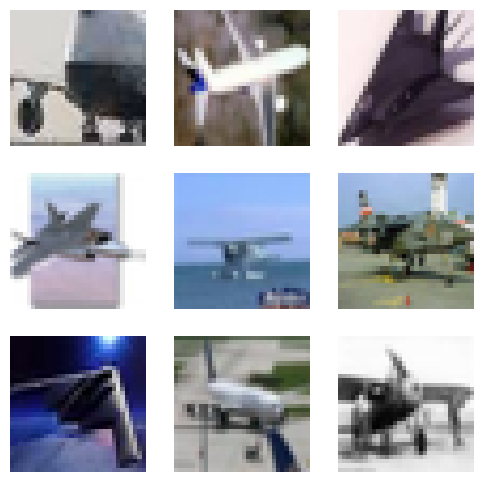

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

# 我们需要的图片数量
num_images_to_display = 9

# 已经显示的图片数量
images_displayed = 0

# 遍历训练数据直到找到足够的车辆图片
for images, labels in train_loader:
    for image, label in zip(images, labels):
        if label == 0:
            ax = axes[images_displayed // 3, images_displayed % 3]
            # CIFAR-10数据集标准化后要还原为可显示的[0,1]范围
            img = image / 2 + 0.5  # 反标准化
            img = transforms.ToPILImage()(img)  # 转换为PIL图像
            ax.imshow(img)
            ax.axis('off')
            images_displayed += 1
            if images_displayed == num_images_to_display:
                break
    if images_displayed == num_images_to_display:
        break

# 显示图像
plt.show()

In [ ]:
# epochs = 20

# for epoch in range(epochs):
#     total_loss = 0
#     for step, (images, labels) in enumerate(train_loader):
#         optimizer.zero_grad()

#         batch_size = images.shape[0]
#         images = images.to(device)

#         # sample t uniformally for every example in the batch
#         t = torch.randint(0, timesteps, (batch_size,), device=device).long()

#         loss = gaussian_diffusion.train_losses(model, images, t)
#         total_loss += loss.item()
#         #if step % 200 == 0:
#         #    print("Loss:", loss.item())


#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch}, Loss {total_loss/len(train_loader)}")

In [ ]:
# #save the trained model in google drive
# model_pth="/content/drive/MyDrive/Unet_model/UNet_5.pth"
# torch.save(model.state_dict(),model_pth)

In [13]:
#load the model
model_pth="/content/drive/MyDrive/Unet_model/UNet_200.pth"
model = UNetModel(
    in_channels=3,
    model_channels=128,
    out_channels=3,
    channel_mult=(1, 2, 2, 2),
    attention_resolutions=(2,),
    dropout=0.1
)
model.to(device)

model.load_state_dict(torch.load(model_pth))

<All keys matched successfully>

In [15]:
my_gaussian_diffusion = GaussianDiffusion(timesteps=1000,beta_schedule='linear',label=0,classifier=classifier)

In [ ]:
generated_images = my_gaussian_diffusion.sample(model, 32, batch_size=64, channels=3)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


sampling loop time step:   0%|          | 2/1000 [00:02<20:40,  1.24s/it]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 2, 1, 3, 1, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 1, 6, 2, 2, 1, 1, 2, 3, 2,
        1, 2, 1, 2, 3, 3, 2, 2, 2, 2, 2, 6, 2, 2, 2, 1], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([2, 1, 2, 1, 1, 1, 2, 9, 2, 1, 2, 1, 1, 2, 9, 0, 1, 1, 1, 1, 2, 2, 5, 1,
        2, 2, 2, 1, 2, 2, 1, 9, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 9, 2, 1, 1, 2, 2,
        2, 1, 2, 1, 2, 1, 1, 2, 1, 9, 1, 1, 1, 9, 5, 9], device='cuda:0')


sampling loop time step:   0%|          | 4/1000 [00:03<08:40,  1.91it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([1, 2, 5, 9, 1, 1, 2, 9, 2, 1, 1, 5, 6, 9, 1, 0, 1, 9, 1, 2, 3, 1, 2, 3,
        1, 9, 2, 9, 3, 1, 2, 9, 9, 1, 6, 1, 6, 9, 1, 1, 2, 1, 9, 1, 6, 2, 1, 2,
        1, 9, 9, 1, 9, 6, 2, 1, 6, 1, 1, 1, 1, 1, 9, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([9, 1, 6, 9, 2, 2, 9, 5, 6, 1, 6, 1, 1, 2, 9, 0, 5, 2, 6, 2, 1, 9, 1, 3,
        9, 2, 2, 9, 3, 1, 1, 9, 9, 9, 1, 1, 1, 5, 9, 9, 9, 1, 9, 1, 1, 1, 2, 9,
        6, 1, 9, 9, 9, 5, 5, 1, 1, 2, 2, 9, 2, 0, 9, 0], device='cuda:0')


sampling loop time step:   1%|          | 6/1000 [00:03<05:18,  3.12it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([6, 1, 1, 0, 1, 1, 2, 3, 5, 1, 9, 9, 1, 9, 2, 0, 0, 9, 1, 9, 2, 9, 5, 3,
        9, 9, 2, 1, 0, 9, 6, 5, 9, 9, 1, 5, 1, 1, 9, 6, 0, 1, 0, 1, 9, 9, 1, 9,
        5, 9, 5, 9, 9, 1, 2, 5, 9, 9, 1, 1, 2, 0, 9, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([9, 1, 2, 0, 2, 2, 9, 9, 6, 9, 1, 0, 1, 9, 5, 0, 0, 0, 1, 2, 1, 0, 9, 3,
        9, 9, 1, 9, 0, 2, 9, 9, 9, 9, 1, 3, 9, 9, 9, 3, 0, 1, 0, 1, 0, 9, 2, 9,
        9, 1, 6, 9, 9, 9, 5, 9, 1, 1, 6, 9, 1, 0, 9, 0], device='cuda:0')


sampling loop time step:   1%|          | 8/1000 [00:03<03:57,  4.17it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 3, 1, 0, 2, 3, 6, 0, 1, 9, 9, 0, 3, 9, 9, 0, 0, 0, 1, 9, 5, 0, 9, 0,
        9, 9, 1, 9, 0, 9, 9, 0, 9, 9, 1, 3, 9, 9, 9, 3, 0, 3, 0, 2, 0, 9, 3, 9,
        9, 0, 9, 9, 9, 9, 9, 2, 1, 5, 5, 9, 0, 0, 9, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 3, 0, 0, 1, 9, 3, 0, 0, 9, 0, 0, 3, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        9, 9, 2, 0, 0, 9, 9, 0, 9, 9, 6, 0, 9, 9, 1, 3, 0, 9, 0, 1, 0, 9, 9, 9,
        9, 0, 9, 9, 0, 9, 9, 0, 9, 1, 9, 9, 0, 0, 9, 0], device='cuda:0')


sampling loop time step:   1%|          | 11/1000 [00:04<03:09,  5.21it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 3, 0, 0, 2, 2, 3, 0, 0, 9, 0, 0, 3, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        9, 9, 1, 0, 0, 9, 0, 0, 9, 9, 6, 0, 9, 9, 9, 3, 0, 3, 0, 6, 0, 9, 9, 0,
        9, 0, 5, 0, 0, 9, 2, 0, 9, 9, 9, 9, 0, 0, 9, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 3, 0, 0, 5, 2, 6, 0, 0, 9, 0, 0, 6, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 6, 6, 0, 0, 9, 0, 0, 9, 6, 6, 0, 9, 9, 0, 3, 0, 0, 0, 1, 0, 0, 9, 0,
        9, 0, 9, 0, 0, 9, 0, 0, 9, 9, 9, 9, 0, 0, 9, 0], device='cuda:0')


sampling loop time step:   1%|▏         | 13/1000 [00:04<02:57,  5.55it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 3, 0, 0, 3, 3, 3, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 6, 0, 0, 0, 0, 0, 0, 9, 6, 0, 0, 1, 0, 3, 0, 0, 0, 3, 0, 0, 9, 0,
        0, 0, 9, 0, 0, 9, 0, 0, 9, 9, 9, 9, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 5, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 3, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 3, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 9, 0, 0, 9, 0, 0, 1, 9, 9, 9, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   1%|▏         | 14/1000 [00:04<02:55,  5.61it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 5, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   2%|▏         | 16/1000 [00:05<02:50,  5.77it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 3, 2, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 5, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   2%|▏         | 18/1000 [00:05<02:49,  5.80it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 5, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   2%|▏         | 20/1000 [00:06<02:51,  5.72it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 5, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   2%|▏         | 22/1000 [00:06<02:49,  5.79it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   2%|▏         | 24/1000 [00:06<02:47,  5.82it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   3%|▎         | 26/1000 [00:07<02:47,  5.81it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   3%|▎         | 28/1000 [00:07<02:46,  5.86it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   3%|▎         | 30/1000 [00:07<02:45,  5.86it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   3%|▎         | 32/1000 [00:08<02:46,  5.81it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   3%|▎         | 34/1000 [00:08<02:46,  5.80it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   4%|▎         | 36/1000 [00:08<02:46,  5.80it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   4%|▍         | 38/1000 [00:09<02:45,  5.80it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   4%|▍         | 40/1000 [00:09<02:44,  5.83it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   4%|▍         | 42/1000 [00:09<02:43,  5.85it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   4%|▍         | 44/1000 [00:10<02:43,  5.85it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   5%|▍         | 46/1000 [00:10<02:42,  5.86it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   5%|▍         | 48/1000 [00:10<02:42,  5.84it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   5%|▌         | 50/1000 [00:11<02:43,  5.81it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   5%|▌         | 52/1000 [00:11<02:45,  5.72it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   5%|▌         | 54/1000 [00:11<02:44,  5.76it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   6%|▌         | 56/1000 [00:12<02:43,  5.77it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   6%|▌         | 58/1000 [00:12<02:42,  5.79it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   6%|▌         | 60/1000 [00:12<02:41,  5.82it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   6%|▌         | 62/1000 [00:13<02:42,  5.78it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   6%|▋         | 64/1000 [00:13<02:42,  5.77it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   7%|▋         | 66/1000 [00:13<02:42,  5.74it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   7%|▋         | 68/1000 [00:14<02:43,  5.71it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   7%|▋         | 70/1000 [00:14<02:42,  5.74it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   7%|▋         | 72/1000 [00:14<02:40,  5.79it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   7%|▋         | 74/1000 [00:15<02:39,  5.80it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   8%|▊         | 76/1000 [00:15<02:39,  5.79it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   8%|▊         | 78/1000 [00:16<02:40,  5.75it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   8%|▊         | 80/1000 [00:16<02:41,  5.69it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   8%|▊         | 82/1000 [00:16<02:39,  5.74it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   8%|▊         | 84/1000 [00:17<02:38,  5.78it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   9%|▊         | 86/1000 [00:17<02:37,  5.79it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   9%|▉         | 88/1000 [00:17<02:36,  5.83it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   9%|▉         | 90/1000 [00:18<02:35,  5.84it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   9%|▉         | 92/1000 [00:18<02:36,  5.81it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:   9%|▉         | 94/1000 [00:18<02:37,  5.76it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  10%|▉         | 96/1000 [00:19<02:36,  5.76it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  10%|▉         | 98/1000 [00:19<02:35,  5.80it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  10%|█         | 100/1000 [00:19<02:35,  5.78it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  10%|█         | 102/1000 [00:20<02:34,  5.82it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  10%|█         | 104/1000 [00:20<02:34,  5.79it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  11%|█         | 106/1000 [00:20<02:34,  5.78it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  11%|█         | 108/1000 [00:21<02:34,  5.76it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  11%|█         | 110/1000 [00:21<02:35,  5.73it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  11%|█         | 112/1000 [00:21<02:33,  5.78it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  11%|█▏        | 114/1000 [00:22<02:32,  5.80it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  12%|█▏        | 116/1000 [00:22<02:33,  5.76it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  12%|█▏        | 118/1000 [00:22<02:32,  5.79it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  12%|█▏        | 120/1000 [00:23<02:31,  5.82it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  12%|█▏        | 122/1000 [00:23<02:31,  5.79it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  12%|█▏        | 124/1000 [00:23<02:31,  5.77it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  13%|█▎        | 126/1000 [00:24<02:31,  5.78it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  13%|█▎        | 128/1000 [00:24<02:30,  5.79it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  13%|█▎        | 130/1000 [00:25<02:29,  5.82it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  13%|█▎        | 132/1000 [00:25<02:29,  5.81it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  13%|█▎        | 134/1000 [00:25<02:29,  5.80it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  14%|█▎        | 136/1000 [00:26<02:30,  5.75it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  14%|█▍        | 138/1000 [00:26<02:31,  5.71it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  14%|█▍        | 140/1000 [00:26<02:30,  5.70it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  14%|█▍        | 142/1000 [00:27<02:30,  5.69it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  14%|█▍        | 144/1000 [00:27<02:29,  5.72it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  15%|█▍        | 146/1000 [00:27<02:29,  5.70it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  15%|█▍        | 148/1000 [00:28<02:30,  5.64it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

sampling loop time step:  15%|█▍        | 149/1000 [00:28<02:32,  5.59it/s]


this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  15%|█▌        | 151/1000 [00:28<02:33,  5.51it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])


sampling loop time step:  15%|█▌        | 153/1000 [00:29<02:33,  5.52it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  15%|█▌        | 154/1000 [00:29<02:31,  5.57it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  16%|█▌        | 156/1000 [00:29<02:29,  5.66it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  16%|█▌        | 158/1000 [00:29<02:27,  5.73it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  16%|█▌        | 160/1000 [00:30<02:26,  5.74it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  16%|█▌        | 162/1000 [00:30<02:27,  5.68it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


sampling loop time step:  16%|█▋        | 164/1000 [00:31<02:28,  5.63it/s]

this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])
tensor([0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
this is model mean torch.Size([64, 3, 32, 32])
this is posterior variance torch.Size([64, 1, 1, 1])
torch.Size([64, 3, 32, 32])


sampling loop time step:  16%|█▋        | 165/1000 [00:31<02:29,  5.58it/s]

In [ ]:
# generate new images(actually some examples from the the results got by other people)
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 3, 32, 32)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = np.array((imgs[n_row, n_col].transpose([1, 2, 0])+1.0) * 255 / 2, dtype=np.uint8)
        f_ax.imshow(img)
        f_ax.axis("off")

In [ ]:
#print(generated_images[-1])
labels=classifier(torch.tensor(generated_images[-1]).to('cuda'))
_, predicted = torch.max(labels, 1)
print(predicted)

In [ ]:
my_gaussian_diffusion2 = GaussianDiffusion(timesteps=1000,beta_schedule='linear',label=4,classifier=classifier)

In [ ]:
generated_images2 = my_gaussian_diffusion2.sample(model, 32, batch_size=64, channels=3)

In [ ]:
# generate new images(actually some examples from the the results got by other people)
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images2[-1].reshape(8, 8, 3, 32, 32)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = np.array((imgs[n_row, n_col].transpose([1, 2, 0])+1.0) * 255 / 2, dtype=np.uint8)
        f_ax.imshow(img)
        f_ax.axis("off")

In [ ]:
#print(generated_images[-1])
labels=classifier(torch.tensor(generated_images2[-1]).to('cuda'))
_, predicted = torch.max(labels, 1)
print(predicted)

In [ ]:
my_gaussian_diffusion3 = GaussianDiffusion(timesteps=1000,beta_schedule='linear',label=2,classifier=classifier)

In [ ]:
generated_images3 = my_gaussian_diffusion3.sample(model, 32, batch_size=64, channels=3)

In [ ]:
# generate new images(actually some examples from the the results got by other people)
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images3[-1].reshape(8, 8, 3, 32, 32)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = np.array((imgs[n_row, n_col].transpose([1, 2, 0])+1.0) * 255 / 2, dtype=np.uint8)
        f_ax.imshow(img)
        f_ax.axis("off")

In [ ]:
labels=classifier(torch.tensor(generated_images3[-1]).to('cuda'))
_, predicted = torch.max(labels, 1)
print(predicted)

In [ ]:
my_gaussian_diffusion4 = GaussianDiffusion(timesteps=1000,beta_schedule='linear',label=3,classifier=classifier)

In [ ]:
generated_images4 = my_gaussian_diffusion4.sample(model, 32, batch_size=64, channels=3)

In [ ]:
# generate new images(actually some examples from the the results got by other people)
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images4[-1].reshape(8, 8, 3, 32, 32)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = np.array((imgs[n_row, n_col].transpose([1, 2, 0])+1.0) * 255 / 2, dtype=np.uint8)
        f_ax.imshow(img)
        f_ax.axis("off")

In [ ]:
labels=classifier(torch.tensor(generated_images4[-1]).to('cuda'))
_, predicted = torch.max(labels, 1)
print(predicted)

In [ ]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

for n_row in range(16):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].reshape(3, 32, 32).transpose([1, 2, 0])
        f_ax.imshow(np.array((img+1.0) * 255 / 2, dtype=np.uint8))
        f_ax.axis("off")